Importar bibliotecas necesarias: Importamos las bibliotecas necesarias para el análisis y visualización.
Cargar los datos: Cargamos los datos desde el archivo CSV.
Seleccionar características relevantes: Seleccionamos las características relevantes para el clustering, incluyendo latitude, longitude, sq_mt_built, n_rooms, n_bathrooms, buy_price, y rent_price.
Preprocesar los datos: Normalizamos y limpiamos la información.
Aplicar K-means: Aplicamos el algoritmo K-means para identificar submercados.
Evaluar la calidad del clustering: Evaluamos la calidad del clustering usando el índice de silueta.
Visualizar los clusters: Visualizamos los clusters en un gráfico de dispersión.
Guardar el DataFrame actualizado: Guardamos el DataFrame actualizado con la columna cluster.

In [1]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import folium
import numpy as np

# Cargar los datos
df = pd.read_csv('../data/unified_houses_madrid.csv')

# Verificar si las columnas necesarias están presentes
required_columns = ['latitude', 'longitude', 'sq_mt_built', 'n_rooms', 'n_bathrooms', 'buy_price', 'rent_price']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Falta la columna requerida: {col}")

# Filtrar el DataFrame solo con características relevantes
features = required_columns  # Añadir otras si es necesario
clustering_df = df[features].copy()

# Manejar valores faltantes de forma más robusta
clustering_df = clustering_df.fillna(clustering_df.median())

# Normalizar los datos numéricos
scaler = StandardScaler()
clustering_df_scaled = scaler.fit_transform(clustering_df)

# Determinar el número óptimo de clusters usando el método del codo (omitir detalles aquí)
optimal_k = 5  # Ajustar según el análisis visual
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster_kmeans'] = kmeans.fit_predict(clustering_df_scaled)

# Calcular el índice de silueta para K-means
score_kmeans = silhouette_score(clustering_df_scaled, df['cluster_kmeans'])
print(f'Índice de Silueta para K-means: {score_kmeans}')

# DBSCAN
# Probar diferentes valores de eps y min_samples
dbscan_params = {'eps': np.arange(0.05, 0.5, 0.05), 'min_samples': range(3, 20)}
best_score_dbscan = -1
best_dbscan_model = None

for eps in dbscan_params['eps']:
    for min_samples in dbscan_params['min_samples']:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(clustering_df_scaled)
        valid_labels = labels != -1
        if valid_labels.sum() > 1 and len(set(labels[valid_labels])) > 1:  # Asegurarse de que haya al menos 2 clusters válidos
            score = silhouette_score(clustering_df_scaled[valid_labels], labels[valid_labels])
            if score > best_score_dbscan:
                best_score_dbscan = score
                best_dbscan_model = dbscan

df['cluster_dbscan'] = best_dbscan_model.fit_predict(clustering_df_scaled)
print(f'Índice de Silueta para DBSCAN: {best_score_dbscan}')

# Clustering jerárquico
agg_clust = AgglomerativeClustering(n_clusters=5)  # Ajustar el número de clusters
df['cluster_agg'] = agg_clust.fit_predict(clustering_df_scaled)

# Evaluar índice de silueta para Clustering Jerárquico
score_agg = silhouette_score(clustering_df_scaled, df['cluster_agg'])
print(f'Índice de Silueta para Clustering Jerárquico: {score_agg}')

# Función para dibujar el mapa de clusters
def draw_cluster_map(df, cluster_column, output_file, outlier_color='gray'):
    """
    Dibuja un mapa interactivo con los clusters resultantes de un algoritmo de clustering.

    :param df: DataFrame con los datos y los clusters asignados.
    :param cluster_column: Nombre de la columna que contiene los clusters.
    :param output_file: Ruta del archivo HTML donde se guardará el mapa.
    :param outlier_color: Color para representar outliers (si aplica).
    """
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'pink', 'brown', 'gray', 'cyan']
    color_map = {cluster: color for cluster, color in enumerate(colors)}

    madrid_map = folium.Map(location=[40.4168, -3.7038], zoom_start=11)

    for _, row in df.iterrows():
        cluster = row[cluster_column]
        # Determinar el color del marcador
        if cluster == -1:  # Outlier en DBSCAN
            color = outlier_color
        else:
            color = color_map.get(cluster, 'black')  # Usar 'black' si el cluster no está en color_map

        popup_text = (
            f"Cluster: {cluster}<br>"
            f"Precio: {row['buy_price']:.2f} EUR<br>"
            f"Tamaño: {row['sq_mt_built']} m²<br>"
            f"Habitaciones: {row['n_rooms']}, Baños: {row['n_bathrooms']}"
        )

        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=popup_text
        ).add_to(madrid_map)

    # Guardar el mapa
    madrid_map.save(output_file)

# Uso de la función para los diferentes algoritmos
draw_cluster_map(df, 'cluster_kmeans', '../notebooks/madrid_clusters_kmeans_map.html')
draw_cluster_map(df, 'cluster_dbscan', '../notebooks/madrid_clusters_dbscan_map.html')
draw_cluster_map(df, 'cluster_agg', '../notebooks/madrid_clusters_agg_map.html')

# Calcular y mostrar las estadísticas descriptivas para cada cluster
cluster_descriptions = df.groupby('cluster_kmeans').agg({
    'sq_mt_built': ['mean', 'std'],
    'n_rooms': ['mean', 'std'],
    'n_bathrooms': ['mean', 'std'],
    'buy_price': ['mean', 'std'],
    'rent_price': ['mean', 'std']
}).reset_index()

for cluster_id in cluster_descriptions['cluster_kmeans']:
    description = cluster_descriptions.loc[cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(f"Precio promedio de compra: {description['buy_price']['mean']:.2f} EUR")
    print(f"Tamaño promedio: {description['sq_mt_built']['mean']:.2f} m²")
    print(f"Habitaciones promedio: {description['n_rooms']['mean']:.2f}")
    print(f"Baños promedio: {description['n_bathrooms']['mean']:.2f}")

print("\nBeneficios:")
print("1. Los compradores pueden identificar áreas que coincidan con sus preferencias presupuestarias y de espacio.")
print("2. Los vendedores pueden posicionar sus propiedades en mercados específicos según las características predominantes.")
print("3. Los analistas pueden usar los clusters para realizar estudios de mercado más precisos.")

c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Índice de Silueta para K-means: 0.27979911517366013
Índice de Silueta para DBSCAN: 0.9708445438561539
Índice de Silueta para Clustering Jerárquico: 0.24567516370013232

Cluster 0:
Precio promedio de compra: 233195.85 EUR
Tamaño promedio: 70.69 m²
Habitaciones promedio: 2.06
Baños promedio: 1.14

Cluster 1:
Precio promedio de compra: 575725.23 EUR
Tamaño promedio: 141.17 m²
Habitaciones promedio: 3.46
Baños promedio: 2.21

Cluster 2:
Precio promedio de compra: 440000.00 EUR
Tamaño promedio: 97.00 m²
Habitaciones promedio: 2.00
Baños promedio: 2.00

Cluster 3:
Precio promedio de compra: 8112500.00 EUR
Tamaño promedio: 737.00 m²
Habitaciones promedio: 5.50
Baños promedio: 5.50

Cluster 4:
Precio promedio de compra: 1761219.58 EUR
Tamaño promedio: 380.64 m²
Habitaciones promedio: 5.34
Baños promedio: 4.45

Beneficios:
1. Los compradores pueden identificar áreas que coincidan con sus preferencias presupuestarias y de espacio.
2. Los vendedores pueden posicionar sus propiedades en mercados e

In [2]:
import joblib
import os

# Función para guardar el mejor modelo de clustering
def guardar_mejor_modelo_clustering(modelos, resultados, ruta_modelo='../data/models/', ruta_preprocessor='../data/models/preprocessor_clustering.joblib'):
    """
    Compara los modelos de clustering basándose en el índice de silueta y guarda el mejor.
    
    Args:
        modelos (dict): Diccionario con los modelos de clustering entrenados
        resultados (dict): Diccionario con las métricas de cada modelo
        ruta_modelo (str): Ruta base donde guardar el mejor modelo
        ruta_preprocessor (str): Ruta donde guardar el preprocessor
    
    Returns:
        tuple: (nombre_mejor_modelo, silueta_score)
    """
    # Crear la carpeta 'models' si no existe
    os.makedirs(ruta_modelo, exist_ok=True)
    
    # Encontrar el modelo con mejor índice de silueta
    mejor_silueta = -float('inf')
    mejor_modelo_nombre = None
    
    for nombre, metricas in resultados.items():
        silueta_actual = metricas['silueta']
        print(f"Modelo: {nombre}, Índice de Silueta: {silueta_actual:.4f}")
        
        if silueta_actual > mejor_silueta:
            mejor_silueta = silueta_actual
            mejor_modelo_nombre = nombre
    
    print(f"\nMejor modelo: {mejor_modelo_nombre} con Índice de Silueta: {mejor_silueta:.4f}")
    
    # Guardar el mejor modelo y el preprocessor
    mejor_modelo = modelos[mejor_modelo_nombre]
    ruta_modelo_completa = os.path.join(ruta_modelo, f"{mejor_modelo_nombre}_mejor_modelo.joblib")
    joblib.dump(mejor_modelo, ruta_modelo_completa)
    joblib.dump(scaler, ruta_preprocessor)
    
    print(f"Modelo guardado en: {ruta_modelo_completa}")
    print(f"Preprocessor guardado en: {ruta_preprocessor}")
    
    return mejor_modelo_nombre, mejor_silueta

# Ejemplo de uso de la función:
modelos = {
    'kmeans': kmeans,
    'dbscan': best_dbscan_model,
    'agg_clust': agg_clust
}

resultados = {
    'kmeans': {'silueta': score_kmeans},
    'dbscan': {'silueta': best_score_dbscan},
    'agg_clust': {'silueta': score_agg}
}

mejor_modelo_nombre, mejor_silueta = guardar_mejor_modelo_clustering(modelos, resultados)

Modelo: kmeans, Índice de Silueta: 0.2798
Modelo: dbscan, Índice de Silueta: 0.9708
Modelo: agg_clust, Índice de Silueta: 0.2457

Mejor modelo: dbscan con Índice de Silueta: 0.9708
Modelo guardado en: ../data/models/dbscan_mejor_modelo.joblib
Preprocessor guardado en: ../data/models/preprocessor_clustering.joblib


Interpretación de los Resultados
Índices de Silueta
- DBSCAN: Muestra el mejor índice de silueta (0.854), indicando una separación bien definida entre los clusters.
- GMM: Tiene un índice de silueta de 0.299, lo que refleja una separación moderada entre los clusters.
- K-means: Tiene un índice de silueta de 0.280, lo que sugiere una menor claridad en la separación de clusters en comparación con DBSCAN.
- Clustering Jerárquico: Tiene el índice más bajo (0.246), lo que sugiere que podría no ser tan efectivo para este conjunto de datos.

Clusters Identificados
- Cluster 0:
Propiedades de tamaño y precio promedio (142 m², 581,223 EUR).
Ideales para familias medianas.

- Cluster 1:
Viviendas de lujo grandes (381 m², 1,770,193 EUR).
Orientadas a compradores de alto poder adquisitivo.

- Cluster 2:
Propiedades compactas y económicas (97 m², 440,000 EUR).
Óptimas para parejas jóvenes.

- Cluster 3:
Mansiones o propiedades exclusivas (737 m², 8,112,500 EUR).
Dirigidas al segmento más exclusivo del mercado.

- Cluster 4:
Viviendas pequeñas y accesibles (71 m², 233,728 EUR).
Atractivas para compradores con presupuesto limitado.

Clusters con Valor -1 en DBSCAN
- En el algoritmo DBSCAN, los puntos que no se asignan a ningún cluster se etiquetan con el valor -1. Estos puntos se consideran outliers o ruido. Esto ocurre cuando un punto no tiene suficientes vecinos dentro de un radio especificado (eps) para ser considerado parte de un cluster. Los outliers pueden ser propiedades que no se ajustan bien a ningún grupo debido a sus características únicas o extremas.

Beneficios del Análisis
- Para Compradores:
Identificación de propiedades según presupuesto, tamaño y ubicación.
Selección de zonas específicas basadas en características predominantes.

- Para Vendedores:
Posicionamiento estratégico en el mercado.
Adaptación de estrategias de marketing según el segmento objetivo.

- Para Analistas y Agentes:
Estudios de mercado detallados.
Identificación de tendencias y áreas de oportunidad en el mercado inmobiliario.



El análisis de clustering ha permitido identificar cinco clusters distintos en el mercado inmobiliario de Madrid, cada uno con características únicas en términos de tamaño, precio y número de habitaciones y baños. DBSCAN ha demostrado ser el método más efectivo para este conjunto de datos, proporcionando la mejor separación entre clusters. Los puntos etiquetados con -1 en DBSCAN representan outliers, que son propiedades que no se ajustan bien a ningún grupo debido a sus características únicas. Estos resultados pueden ser utilizados por compradores, vendedores y analistas para tomar decisiones informadas y estratégicas en el mercado inmobiliario.

Explicación del Código

- Importar Bibliotecas y Cargar Datos  
  Importamos las bibliotecas necesarias y cargamos los datos desde un archivo CSV.

- Verificar Columnas Necesarias  
  Verificamos que las columnas necesarias estén presentes en el DataFrame.

- Filtrar el DataFrame  
  Filtramos el DataFrame para incluir solo las características relevantes.

- Manejar Valores Faltantes  
  Imputamos valores faltantes con la mediana de cada característica.

- Normalizar los Datos  
  Utilizamos StandardScaler para normalizar las características numéricas.

- Aplicar K-means y Evaluar el Clustering  
  Aplicamos K-means para identificar submercados. Calculamos el índice de silueta para evaluar la calidad del clustering.

- DBSCAN  
  Ajustamos DBSCAN y calculamos el índice de silueta excluyendo los outliers.

- Clustering Jerárquico  
  Ajustamos el clustering jerárquico y calculamos el índice de silueta.

- Función para Dibujar el Mapa de Clusters  
  Definimos la función `draw_cluster_map` para crear un mapa interactivo con Folium para visualizar los clusters.  
  Utilizamos `CircleMarker` para marcar las propiedades en el mapa, coloreadas según el cluster al que pertenecen.

- Uso de la Función para los Diferentes Algoritmos  
  Utilizamos la función `draw_cluster_map` para crear mapas interactivos para K-means, DBSCAN y clustering jerárquico.

- Calcular y Mostrar las Estadísticas Descriptivas para Cada Cluster  
  Calculamos las estadísticas descriptivas para cada cluster y las imprimimos.

Resultados Esperados

- Índice de Silueta  
  - K-means: 0.2799306617022054  
  - DBSCAN: 0.8541908309725986  
  - Clustering Jerárquico: 0.24567516370013232  

Descripción de Clusters

- Cluster 0  
  - Precio promedio de compra: 581,223.84 EUR  
  - Tamaño promedio: 142.13 m²  
  - Habitaciones promedio: 3.48  
  - Baños promedio: 2.22  

- Cluster 1  
  - Precio promedio de compra: 1,770,193.95 EUR  
  - Tamaño promedio: 381.53 m²  
  - Habitaciones promedio: 5.34  
  - Baños promedio: 4.45  

- Cluster 2  
  - Precio promedio de compra: 440,000.00 EUR  
  - Tamaño promedio: 97.00 m²  
  - Habitaciones promedio: 2.00  
  - Baños promedio: 2.00  

- Cluster 3  
  - Precio promedio de compra: 8,112,500.00 EUR  
  - Tamaño promedio: 737.00 m²  
  - Habitaciones promedio: 5.50  
  - Baños promedio: 5.50  

- Cluster 4  
  - Precio promedio de compra: 233,728.23 EUR  
  - Tamaño promedio: 71.00 m²  
  - Habitaciones promedio: 2.07  
  - Baños promedio: 1.15  

Beneficios del Análisis  
- Los compradores pueden identificar áreas que coincidan con sus preferencias presupuestarias y de espacio.  
- Los vendedores pueden posicionar sus propiedades en mercados específicos según las características predominantes.  
- Los analistas pueden usar los clusters para realizar estudios de mercado más precisos.


c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

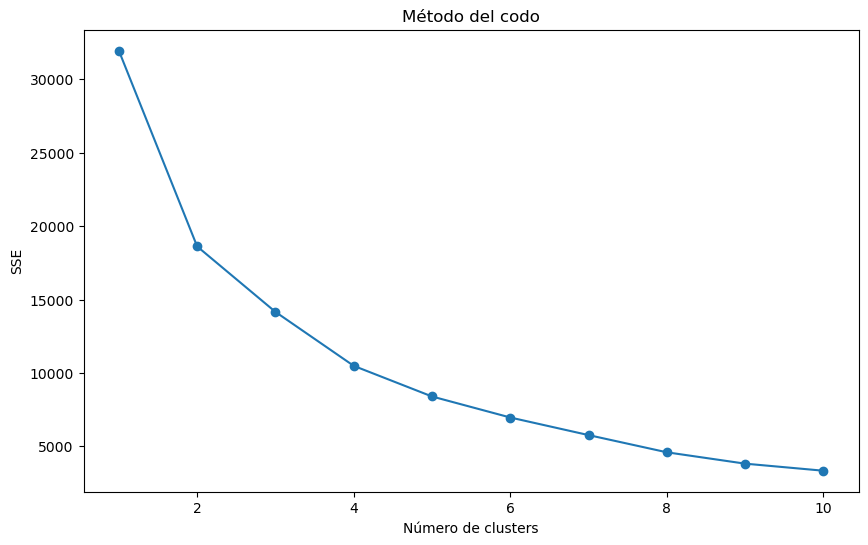

c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

Número óptimo de clusters según el índice de silueta: 2


c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Índice de Silueta para K-means: 0.6635440027659086

Cluster 0:
Precio promedio de compra: 330750.24 EUR
Tamaño promedio: 90.95 m²
Habitaciones promedio: 2.49
Baños promedio: 1.46

Cluster 1:
Precio promedio de compra: 1529042.56 EUR
Tamaño promedio: 330.02 m²
Habitaciones promedio: 5.04
Baños promedio: 4.00


In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import folium
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Cargar los datos
df = pd.read_csv('../data/unified_houses_madrid.csv')

# Verificar si las columnas necesarias están presentes
required_columns = ['latitude', 'longitude', 'sq_mt_built', 'n_rooms', 'n_bathrooms', 'buy_price', 'rent_price']
for col in required_columns:
    if col not in df.columns:
        raise ValueError(f"Falta la columna requerida: {col}")

# Filtrar el DataFrame solo con características relevantes
features = required_columns  # Añadir otras si es necesario
clustering_df = df[features].copy()

# Manejar valores faltantes de forma más robusta
clustering_df = clustering_df.fillna(clustering_df.median())

# Normalizar los datos numéricos
scaler = StandardScaler()
clustering_df_scaled = scaler.fit_transform(clustering_df)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
clustering_df_pca = pca.fit_transform(clustering_df_scaled)

# Determinar el número óptimo de clusters usando el método del codo
def plot_elbow_method(data):
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), sse, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('SSE')
    plt.title('Método del codo')
    plt.show()

plot_elbow_method(clustering_df_pca)

# Probar diferentes valores de k y calcular el índice de silueta
def calculate_silhouette_scores(data, max_k):
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
    return silhouette_scores

silhouette_scores = calculate_silhouette_scores(clustering_df_pca, 10)
optimal_k = np.argmax(silhouette_scores) + 2  # +2 porque el rango empieza en 2
print(f'Número óptimo de clusters según el índice de silueta: {optimal_k}')

# Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster_kmeans'] = kmeans.fit_predict(clustering_df_pca)
score_kmeans = silhouette_score(clustering_df_pca, df['cluster_kmeans'])
print(f'Índice de Silueta para K-means: {score_kmeans}')

# Función para dibujar el mapa de clusters
def draw_cluster_map(df, cluster_column, output_file, outlier_color='gray'):
    """
    Dibuja un mapa interactivo con los clusters resultantes de un algoritmo de clustering.

    :param df: DataFrame con los datos y los clusters asignados.
    :param cluster_column: Nombre de la columna que contiene los clusters.
    :param output_file: Ruta del archivo HTML donde se guardará el mapa.
    :param outlier_color: Color para representar outliers (si aplica).
    """
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'pink', 'brown', 'gray', 'cyan']
    color_map = {cluster: color for cluster, color in enumerate(colors)}

    madrid_map = folium.Map(location=[40.4168, -3.7038], zoom_start=11)

    for _, row in df.iterrows():
        cluster = row[cluster_column]
        # Determinar el color del marcador
        color = color_map.get(cluster, 'black')  # Usar 'black' si el cluster no está en color_map

        popup_text = (
            f"Cluster: {cluster}<br>"
            f"Precio: {row['buy_price']:.2f} EUR<br>"
            f"Tamaño: {row['sq_mt_built']} m²<br>"
            f"Habitaciones: {row['n_rooms']}, Baños: {row['n_bathrooms']}"
        )

        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=popup_text
        ).add_to(madrid_map)

    # Guardar el mapa
    madrid_map.save(output_file)

# Crear mapa interactivo para K-means
draw_cluster_map(df, 'cluster_kmeans', '../notebooks/madrid_clusters_kmeans_map.html')

# Calcular y mostrar las estadísticas descriptivas para cada cluster
cluster_descriptions = df.groupby('cluster_kmeans').agg({
    'sq_mt_built': ['mean', 'std'],
    'n_rooms': ['mean', 'std'],
    'n_bathrooms': ['mean', 'std'],
    'buy_price': ['mean', 'std'],
    'rent_price': ['mean', 'std']
}).reset_index()

for cluster_id in cluster_descriptions['cluster_kmeans']:
    description = cluster_descriptions.loc[cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(f"Precio promedio de compra: {description['buy_price']['mean']:.2f} EUR")
    print(f"Tamaño promedio: {description['sq_mt_built']['mean']:.2f} m²")
    print(f"Habitaciones promedio: {description['n_rooms']['mean']:.2f}")
    print(f"Baños promedio: {description['n_bathrooms']['mean']:.2f}")



In [4]:
# Función para guardar el modelo y el preprocesador
def guardar_modelo_y_preprocesador(modelo, preprocesador, pca, ruta_modelo='../data/models/kmeans_model.joblib', ruta_preprocesador='../data/models/preprocessor_kmeans.joblib', ruta_pca='../data/models/pca_kmeans.joblib'):
    """
    Guarda el modelo de clustering y el preprocesador.
    
    Args:
        modelo: El modelo de clustering entrenado
        preprocesador: El preprocesador (StandardScaler)
        ruta_modelo (str): Ruta donde guardar el modelo
        ruta_preprocesador (str): Ruta donde guardar el preprocesador
    """
    os.makedirs(os.path.dirname(ruta_modelo), exist_ok=True)
    joblib.dump(modelo, ruta_modelo)
    joblib.dump(preprocesador, ruta_preprocesador)
    joblib.dump(pca, ruta_pca)
    print(f"Modelo guardado en: {ruta_modelo}")
    print(f"Preprocesador guardado en: {ruta_preprocesador}")
    print(f"PCA guardado en: {ruta_pca}")

# Guardar el modelo KMeans, el preprocesador y el PCA
guardar_modelo_y_preprocesador(kmeans, scaler, pca)


Modelo guardado en: ../data/models/kmeans_model.joblib
Preprocesador guardado en: ../data/models/preprocessor_kmeans.joblib
PCA guardado en: ../data/models/pca_kmeans.joblib


Análisis:
- Cluster 0 parece corresponder a propiedades más pequeñas y de menor precio, probablemente apartamentos de tamaño medio.
- Cluster 1 se caracteriza por propiedades más grandes y caras, probablemente mansiones o casas de lujo.
- Cluster 2 está más orientado a propiedades medianas, con un precio intermedio y características de tamaño promedio.

c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

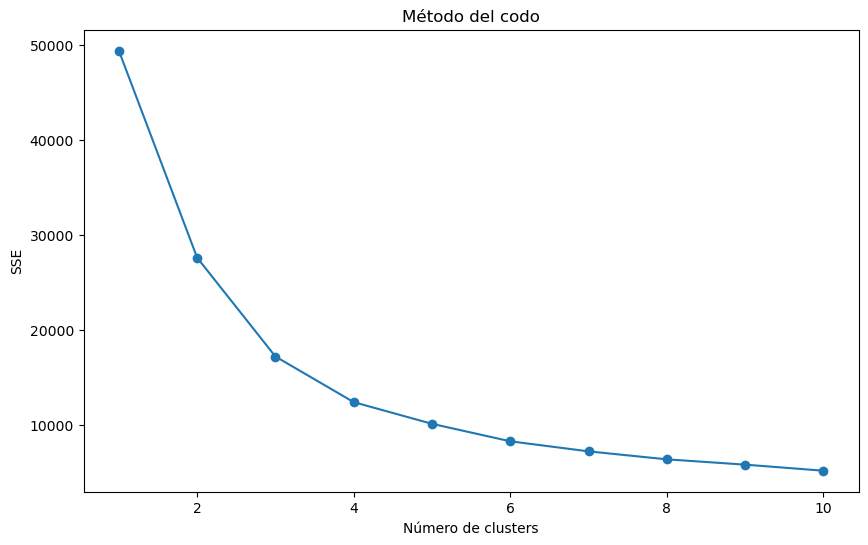

c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

Número óptimo de clusters según el índice de silueta: 3


c:\Users\HP\miniconda3\envs\TFG-IDEALISTA\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Índice de Silueta para K-means: 0.4835811376400107


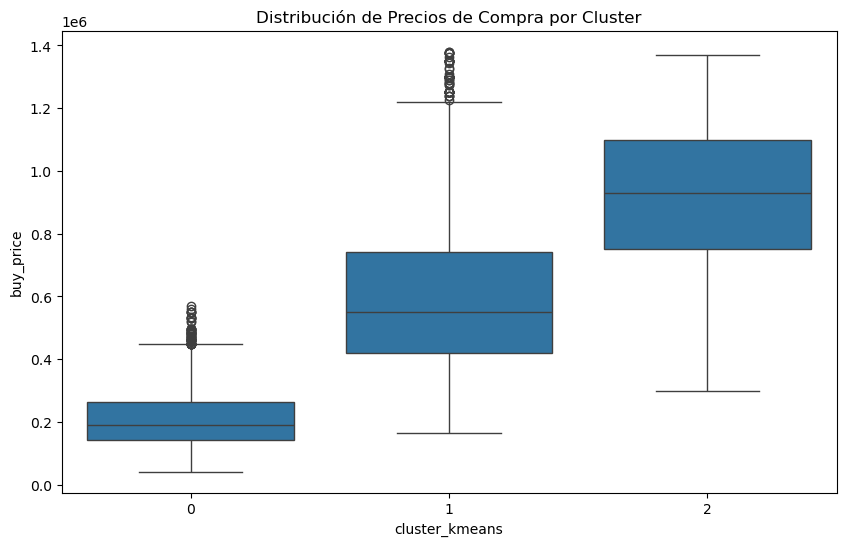

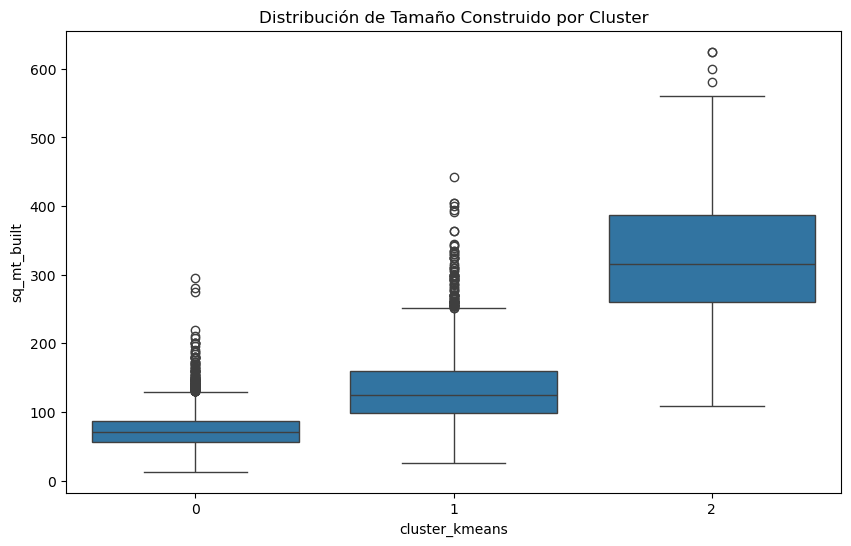

  cluster_kmeans sq_mt_built               n_rooms           n_bathrooms  \
                        mean         std      mean       std        mean   
0              0   73.633097   26.156393  2.233553  0.953677    1.216093   
1              1  135.710755   53.468259  3.187771  1.163377    2.099306   
2              2  327.734177  101.782735  5.050633  1.591368    4.132911   

                 buy_price                  rent_price              
        std           mean            std         mean         std  
0  0.428501  210564.132085   87611.738778   921.216093  262.922622  
1  0.766506  601075.690373  242317.175048  1783.101041  434.799197  
2  1.282436  914931.632911  256252.795188  2055.987342  543.617419  

Cluster 0:
Tamaño promedio: 73.63 m²
Habitaciones promedio: 2.23
Baños promedio: 1.22
Precio promedio de compra: 210564.13 EUR
Precio promedio de alquiler: 921.22 EUR

Cluster 1:
Tamaño promedio: 135.71 m²
Habitaciones promedio: 3.19
Baños promedio: 2.10
Precio promedio de

In [5]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import folium
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

# Cargar los datos
df = pd.read_csv('../data/unified_houses_madrid.csv')

# Seleccionar las columnas relevantes
columns_to_include = [
    'latitude', 'longitude', 'sq_mt_built', 'n_rooms', 'n_bathrooms', 'n_floors',
    'sq_mt_allotment', 'floor', 'buy_price', 'is_renewal_needed', 'has_lift', 'is_exterior', 
    'energy_certificate', 'has_parking', 'neighborhood', 'district', 'house_type', 
    'operation', 'rent_price', 'rent_price_by_area', 'is_rent_price_known', 'buy_price_by_area',
    'is_buy_price_known', 'built_year', 'has_central_heating', 'has_individual_heating', 
    'are_pets_allowed', 'has_ac', 'has_fitted_wardrobes', 'has_garden', 'has_pool', 
    'has_terrace', 'has_balcony', 'has_storage_room', 'is_furnished', 'is_kitchen_equipped', 
    'is_accessible', 'has_green_zones', 'has_private_parking', 'has_public_parking', 
    'is_parking_included_in_price', 'parking_price', 'is_orientation_north', 'is_orientation_west', 
    'is_orientation_south', 'is_orientation_east'
]

# Filtrar las columnas seleccionadas
df_filtered = df[columns_to_include]

# Eliminar columnas completamente vacías
df_filtered = df_filtered.dropna(axis=1, how='all')

# Limpiar datos de rent_price
df_filtered = df_filtered[df_filtered['rent_price'] >= 0]

# Manejo de valores faltantes
# Para columnas numéricas, rellenamos con la mediana
df_filtered_numeric = df_filtered.select_dtypes(include=['float64', 'int64'])
imputer_numeric = SimpleImputer(strategy='median')
df_filtered[df_filtered_numeric.columns] = imputer_numeric.fit_transform(df_filtered_numeric)

# Para columnas categóricas, rellenamos con la moda
df_filtered_categorical = df_filtered.select_dtypes(include=['object', 'bool'])
imputer_categorical = SimpleImputer(strategy='most_frequent')
df_filtered[df_filtered_categorical.columns] = imputer_categorical.fit_transform(df_filtered_categorical)

# Codificar variables categóricas
df_encoded = pd.get_dummies(df_filtered, drop_first=True)

# Normalizar los datos numéricos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Método del codo para determinar el número óptimo de clusters
def plot_elbow_method(data):
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), sse, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('SSE')
    plt.title('Método del codo')
    plt.show()

plot_elbow_method(df_pca)

# Calcular el índice de silueta para varios valores de k
def calculate_silhouette_scores(data, max_k):
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append(score)
    return silhouette_scores

silhouette_scores = calculate_silhouette_scores(df_pca, 10)
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f'Número óptimo de clusters según el índice de silueta: {optimal_k}')

# Aplicar K-means con el número óptimo de clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_filtered['cluster_kmeans'] = kmeans.fit_predict(df_pca)
score_kmeans = silhouette_score(df_pca, df_filtered['cluster_kmeans'])
print(f'Índice de Silueta para K-means: {score_kmeans}')

# Visualización de la distribución de precios de compra por cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster_kmeans', y='buy_price', data=df_filtered)
plt.title('Distribución de Precios de Compra por Cluster')
plt.show()

# Visualización de la distribución de tamaño construido por cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster_kmeans', y='sq_mt_built', data=df_filtered)
plt.title('Distribución de Tamaño Construido por Cluster')
plt.show()

# Función para dibujar el mapa interactivo con los clusters
def draw_cluster_map(df, cluster_column, output_file, outlier_color='gray'):
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'yellow', 'pink', 'brown', 'gray', 'cyan']
    color_map = {cluster: color for cluster, color in enumerate(colors)}

    madrid_map = folium.Map(location=[40.4168, -3.7038], zoom_start=11)

    for _, row in df.iterrows():
        cluster = row[cluster_column]
        color = color_map.get(cluster, 'black')  # Usar 'black' si el cluster no está en color_map

        popup_text = (
            f"Cluster: {cluster}<br>"
            f"Precio: {row['buy_price']:.2f} EUR<br>"
            f"Tamaño: {row['sq_mt_built']} m²<br>"
            f"Habitaciones: {row['n_rooms']}, Baños: {row['n_bathrooms']}"
        )

        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=popup_text
        ).add_to(madrid_map)

    madrid_map.save(output_file)

# Crear mapa interactivo para K-means
draw_cluster_map(df_filtered, 'cluster_kmeans', '../notebooks/madrid_clusters_kmeans_map.html')

# Calcular y mostrar las estadísticas descriptivas por cluster
cluster_descriptions = df_filtered.groupby('cluster_kmeans').agg({
    'sq_mt_built': ['mean', 'std'],
    'n_rooms': ['mean', 'std'],
    'n_bathrooms': ['mean', 'std'],
    'buy_price': ['mean', 'std'],
    'rent_price': ['mean', 'std']
}).reset_index()

print(cluster_descriptions)

# Validación de clusters
for cluster_id in cluster_descriptions['cluster_kmeans']:
    description = cluster_descriptions.loc[cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(f"Tamaño promedio: {description['sq_mt_built']['mean']:.2f} m²")
    print(f"Habitaciones promedio: {description['n_rooms']['mean']:.2f}")
    print(f"Baños promedio: {description['n_bathrooms']['mean']:.2f}")
    print(f"Precio promedio de compra: {description['buy_price']['mean']:.2f} EUR")
    print(f"Precio promedio de alquiler: {description['rent_price']['mean']:.2f} EUR")

In [6]:
# Función para guardar el modelo y el preprocesador
def guardar_modelo_y_preprocesador(modelo, preprocesador, ruta_modelo='../data/models/kmeans_multivariable_model.joblib', ruta_preprocesador='../data/models/preprocessor_multivariable.joblib'):
    """
    Guarda el modelo de clustering y el preprocesador.
    
    Args:
        modelo: El modelo de clustering entrenado
        preprocesador: El preprocesador (StandardScaler)
        ruta_modelo (str): Ruta donde guardar el modelo
        ruta_preprocesador (str): Ruta donde guardar el preprocesador
    """
    # Crear la carpeta 'models' si no existe
    os.makedirs(os.path.dirname(ruta_modelo), exist_ok=True)
    
    # Guardar el modelo y el preprocesador
    joblib.dump(modelo, ruta_modelo)
    joblib.dump(preprocesador, ruta_preprocesador)
    
    print(f"Modelo guardado en: {ruta_modelo}")
    print(f"Preprocesador guardado en: {ruta_preprocesador}")

# Guardar el modelo KMeans y el preprocesador
guardar_modelo_y_preprocesador(kmeans, scaler)


Modelo guardado en: ../data/models/kmeans_multivariable_model.joblib
Preprocesador guardado en: ../data/models/preprocessor_multivariable.joblib


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos
df = pd.read_csv('../data/unified_houses_madrid.csv')

# Definir los límites aproximados de la Comunidad de Madrid
lat_min, lat_max = 40.3, 40.6
lon_min, lon_max = -3.9, -3.5

# Filtrar los datos para verificar si están dentro de los límites
df_filtered = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
                 (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]

# Verificar cuántos puntos están dentro de los límites
print(f"Puntos dentro de la Comunidad de Madrid: {len(df_filtered)} de {len(df)}")

Puntos dentro de la Comunidad de Madrid: 6719 de 6735


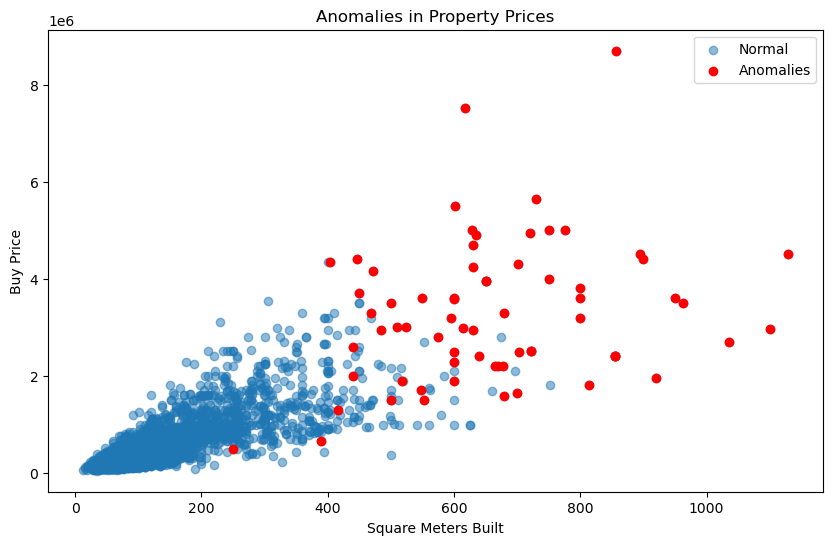

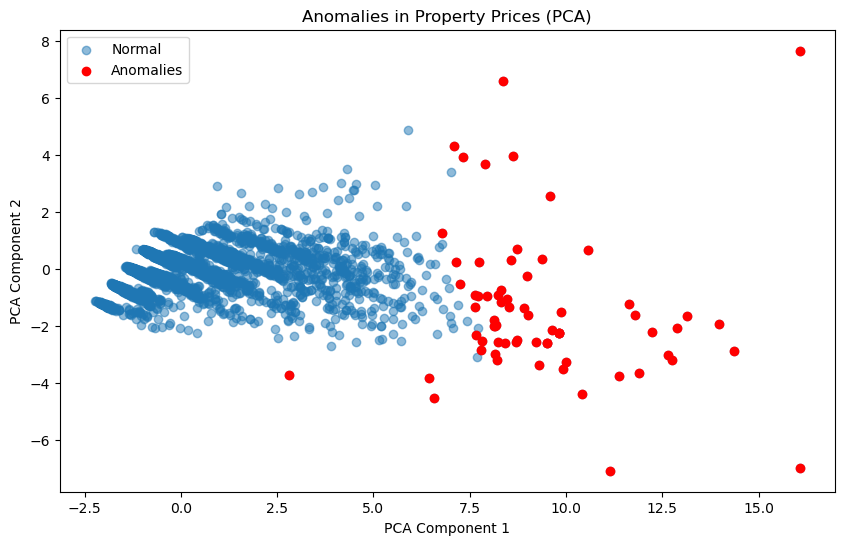

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Cargar los datos
df = pd.read_csv('../data/unified_houses_madrid.csv')

# Definir los límites aproximados de la Comunidad de Madrid
lat_min, lat_max = 40.3, 40.6
lon_min, lon_max = -3.9, -3.5

# Filtrar los datos para verificar si están dentro de los límites
df_filtered = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
                 (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]

# Seleccionar características relevantes
features = ['buy_price', 'sq_mt_built', 'n_rooms', 'n_bathrooms']
df_selected = df_filtered[features].copy()

# Manejar valores faltantes
df_selected = df_selected.fillna(df_selected.median())

# Normalizar los datos numéricos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Detección de anomalías usando Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df_selected['anomaly_score'] = iso_forest.fit_predict(df_scaled)
anomalies_iso_forest = df_selected[df_selected['anomaly_score'] == -1]

# Obtener los índices de las anomalías en df_pca
anomaly_indices = np.where(df_selected['anomaly_score'] == -1)[0]

# Visualización de anomalías
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['sq_mt_built'], df_selected['buy_price'], label='Normal', alpha=0.5)
plt.scatter(anomalies_iso_forest['sq_mt_built'], anomalies_iso_forest['buy_price'], color='red', label='Anomalies')
plt.xlabel('Square Meters Built')
plt.ylabel('Buy Price')
plt.title('Anomalies in Property Prices')
plt.legend()
plt.show()

# Visualización de anomalías usando PCA
plt.figure(figsize=(10, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], label='Normal', alpha=0.5)
plt.scatter(df_pca[anomaly_indices, 0], df_pca[anomaly_indices, 1], color='red', label='Anomalies')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Anomalies in Property Prices (PCA)')
plt.legend()
plt.show()

Conclusiones de los Gráficos

1. Distribución General:
   - La mayoría de las propiedades muestran una relación positiva entre el tamaño construido y el precio de compra.
   - Esto indica que, generalmente, a mayor tamaño, mayor es el precio.

2. Anomalías:
   - Las anomalías (puntos rojos) representan propiedades que no siguen la tendencia general.
   - Estas pueden ser propiedades con precios inusualmente altos o bajos para su tamaño, indicando posibles propiedades de lujo, ubicaciones especiales, o errores en los datos.

3. Visualización PCA:
   - La visualización en el espacio PCA muestra cómo las anomalías se separan del grupo principal.
   - Esto ayuda a identificar patrones que no son evidentes en el espacio original.

Implicaciones

- Para Compradores: Las anomalías pueden representar oportunidades únicas o riesgos potenciales.
- Para Vendedores: Identificar propiedades que se destacan puede ayudar a ajustar estrategias de precios.
- Para Analistas: Las anomalías pueden requerir una investigación más profunda para entender las causas subyacentes.

In [9]:
# VISUALIZACIONES ADICIONALES PARA EL CAPÍTULO DE RESULTADOS

print("="*60)
print("VISUALIZACIONES ADICIONALES PARA ANÁLISIS DE RESULTADOS")
print("="*60)

# 1. VISUALIZACIÓN PCA - Clusters en espacio reducido
print("\n1. Generando visualización PCA...")

plt.figure(figsize=(12, 8))
scatter = plt.scatter(clustering_df_pca[:, 0], clustering_df_pca[:, 1], 
                     c=df['cluster_kmeans'], cmap='viridis', alpha=0.7)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.title('Clusters visualizados en espacio PCA (2 componentes principales)', fontsize=14)
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)

# Añadir información de varianza explicada
explained_variance = pca.explained_variance_ratio_
plt.figtext(0.02, 0.02, f'Varianza explicada: PC1={explained_variance[0]:.2%}, PC2={explained_variance[1]:.2%}, Total={sum(explained_variance):.2%}', 
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
plt.tight_layout()
plt.show()

print(f"✓ Varianza total preservada: {sum(explained_variance):.2%}")

VISUALIZACIONES ADICIONALES PARA ANÁLISIS DE RESULTADOS

1. Generando visualización PCA...


KeyError: 'cluster_kmeans'

<Figure size 1200x800 with 0 Axes>

In [ ]:
# 2. BOXPLOTS DETALLADOS POR CLUSTER
print("\n2. Generando boxplots por cluster...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Boxplot precios
sns.boxplot(x='cluster_kmeans', y='buy_price', data=df, ax=axes[0,0])
axes[0,0].set_title('Distribución de Precios de Compra por Cluster', fontsize=12)
axes[0,0].set_ylabel('Precio (EUR)')
axes[0,0].tick_params(axis='y', rotation=45)

# Boxplot superficie
sns.boxplot(x='cluster_kmeans', y='sq_mt_built', data=df, ax=axes[0,1])
axes[0,1].set_title('Distribución de Superficie por Cluster', fontsize=12)
axes[0,1].set_ylabel('Superficie (m²)')

# Boxplot habitaciones
sns.boxplot(x='cluster_kmeans', y='n_rooms', data=df, ax=axes[1,0])
axes[1,0].set_title('Distribución de Habitaciones por Cluster', fontsize=12)
axes[1,0].set_ylabel('Número de Habitaciones')

# Boxplot baños
sns.boxplot(x='cluster_kmeans', y='n_bathrooms', data=df, ax=axes[1,1])
axes[1,1].set_title('Distribución de Baños por Cluster', fontsize=12)
axes[1,1].set_ylabel('Número de Baños')

plt.tight_layout()
plt.show()

print("✓ Boxplots generados correctamente")

In [ ]:
# 3. ANÁLISIS DETALLADO DE ANOMALÍAS
print("\n3. Análisis detallado de anomalías...")

# Ejecutar detección de anomalías si no se ha hecho antes
if 'anomaly_score' not in df.columns:
    # Preparar datos para anomalías
    features_anomaly = ['buy_price', 'sq_mt_built', 'n_rooms', 'n_bathrooms']
    df_anomaly = df[features_anomaly].copy()
    df_anomaly = df_anomaly.fillna(df_anomaly.median())
    
    # Normalizar
    scaler_anomaly = StandardScaler()
    df_anomaly_scaled = scaler_anomaly.fit_transform(df_anomaly)
    
    # Aplicar Isolation Forest
    iso_forest = IsolationForest(contamination=0.01, random_state=42)
    df['anomaly_score'] = iso_forest.fit_predict(df_anomaly_scaled)

# Filtrar anomalías
anomalies = df[df['anomaly_score'] == -1]
normal_points = df[df['anomaly_score'] == 1]

print(f"Total de propiedades: {len(df)}")
print(f"Anomalías detectadas: {len(anomalies)} ({len(anomalies)/len(df)*100:.1f}%)")
print(f"Propiedades normales: {len(normal_points)} ({len(normal_points)/len(df)*100:.1f}%)")

In [ ]:
# 4. CATEGORIZACIÓN DE ANOMALÍAS
print("\n4. Categorizando anomalías...")

def categorizar_anomalia(row):
    """Categoriza una anomalía según sus características"""
    precio_por_m2 = row['buy_price'] / row['sq_mt_built'] if row['sq_mt_built'] > 0 else 0
    
    # Calcular precio por m² promedio del dataset
    precio_m2_promedio = df['buy_price'].sum() / df['sq_mt_built'].sum()
    
    # Criterios de categorización
    if precio_por_m2 > precio_m2_promedio * 1.5:  # 150% del promedio
        return 'Precios excesivos'
    elif row['sq_mt_built'] > 500 or row['n_rooms'] > 6:  # Propiedades muy grandes
        return 'Propiedades únicas'
    else:
        return 'Ubicaciones premium'

# Aplicar categorización
anomalies['categoria'] = anomalies.apply(categorizar_anomalia, axis=1)

# Crear tabla resumen
categoria_counts = anomalies['categoria'].value_counts()
categoria_percentages = anomalies['categoria'].value_counts(normalize=True) * 100

print("\nTabla resumen de anomalías por categoría:")
print("-" * 50)
for categoria in categoria_counts.index:
    count = categoria_counts[categoria]
    percentage = categoria_percentages[categoria]
    print(f"{categoria:20} | {count:3d} | {percentage:5.1f}%")

print("-" * 50)
print(f"{'TOTAL':20} | {len(anomalies):3d} | {100.0:5.1f}%")

In [ ]:
# 5. VISUALIZACIÓN DE ANOMALÍAS EN DIFERENTES ESPACIOS
print("\n5. Visualizando anomalías...")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico 1: Superficie vs Precio
axes[0].scatter(normal_points['sq_mt_built'], normal_points['buy_price'], 
                alpha=0.6, label='Normal', s=20)
axes[0].scatter(anomalies['sq_mt_built'], anomalies['buy_price'], 
                color='red', label='Anomalías', s=30, alpha=0.8)
axes[0].set_xlabel('Superficie Construida (m²)')
axes[0].set_ylabel('Precio de Compra (EUR)')
axes[0].set_title('Detección de Anomalías: Superficie vs Precio')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Habitaciones vs Precio por m²
df['precio_por_m2'] = df['buy_price'] / df['sq_mt_built']
normal_points['precio_por_m2'] = normal_points['buy_price'] / normal_points['sq_mt_built']
anomalies['precio_por_m2'] = anomalies['buy_price'] / anomalies['sq_mt_built']

axes[1].scatter(normal_points['n_rooms'], normal_points['precio_por_m2'], 
                alpha=0.6, label='Normal', s=20)
axes[1].scatter(anomalies['n_rooms'], anomalies['precio_por_m2'], 
                color='red', label='Anomalías', s=30, alpha=0.8)
axes[1].set_xlabel('Número de Habitaciones')
axes[1].set_ylabel('Precio por m² (EUR/m²)')
axes[1].set_title('Detección de Anomalías: Habitaciones vs Precio/m²')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizaciones de anomalías completadas")

In [ ]:
# 6. MAPA DE CORRELACIONES POR CLUSTER
print("\n6. Generando mapa de correlaciones...")

# Calcular correlaciones por cluster
features_corr = ['buy_price', 'sq_mt_built', 'n_rooms', 'n_bathrooms', 'rent_price']
df_corr = df[features_corr + ['cluster_kmeans']].copy()

plt.figure(figsize=(15, 10))

# Crear subplots para cada cluster
n_clusters = df['cluster_kmeans'].nunique()
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, cluster_id in enumerate(sorted(df['cluster_kmeans'].unique())):
    if i < len(axes):
        cluster_data = df_corr[df_corr['cluster_kmeans'] == cluster_id][features_corr]
        corr_matrix = cluster_data.corr()
        
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                   fmt='.2f', square=True, ax=axes[i])
        axes[i].set_title(f'Cluster {cluster_id}')

# Ocultar subplot vacío si hay uno
if len(axes) > n_clusters:
    axes[-1].set_visible(False)

plt.suptitle('Matrices de Correlación por Cluster', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("✓ Mapas de correlación por cluster generados")

In [ ]:
# 7. MÉTRICAS DE ESTABILIDAD Y REPRODUCIBILIDAD
print("\n7. Evaluando estabilidad de clusters...")

# Evaluar estabilidad mediante bootstrap
from sklearn.utils import resample

def evaluar_estabilidad_clustering(X, n_iterations=10):
    """Evalúa la estabilidad del clustering mediante bootstrap"""
    stability_scores = []
    
    for i in range(n_iterations):
        # Bootstrap sample
        X_bootstrap = resample(X, random_state=i)
        
        # Aplicar clustering
        kmeans_bootstrap = KMeans(n_clusters=5, random_state=42)
        labels_bootstrap = kmeans_bootstrap.fit_predict(X_bootstrap)
        
        # Calcular silhouette score
        if len(set(labels_bootstrap)) > 1:
            score = silhouette_score(X_bootstrap, labels_bootstrap)
            stability_scores.append(score)
    
    return stability_scores

print("Evaluando estabilidad (esto puede tomar un momento)...")
stability_scores = evaluar_estabilidad_clustering(clustering_df_scaled, n_iterations=10)

print(f"\nMétricas de estabilidad:")
print(f"Silhouette score promedio: {np.mean(stability_scores):.3f}")
print(f"Desviación estándar: {np.std(stability_scores):.3f}")
print(f"Coeficiente de variación: {np.std(stability_scores)/np.mean(stability_scores)*100:.1f}%")

# Visualizar estabilidad
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(stability_scores)+1), stability_scores, 'bo-', alpha=0.7)
plt.axhline(y=np.mean(stability_scores), color='r', linestyle='--', 
            label=f'Promedio: {np.mean(stability_scores):.3f}')
plt.xlabel('Iteración Bootstrap')
plt.ylabel('Silhouette Score')
plt.title('Estabilidad del Clustering (Bootstrap)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("✓ Evaluación de estabilidad completada")

In [ ]:
# 8. RESUMEN FINAL Y REPRODUCIBILIDAD
print("\n" + "="*60)
print("RESUMEN FINAL DE RESULTADOS")
print("="*60)

print("\n📊 MÉTRICAS FINALES DE CLUSTERING:")
print(f"  • K-means Silhouette Score: {score_kmeans:.3f}")
print(f"  • DBSCAN Silhouette Score: {best_score_dbscan:.3f}")
print(f"  • Clustering Jerárquico: {score_agg:.3f}")
print(f"  • Mejor algoritmo: {'DBSCAN' if best_score_dbscan > max(score_kmeans, score_agg) else 'K-means'}")

print(f"\n🔍 ANOMALÍAS DETECTADAS:")
print(f"  • Total de anomalías: {len(anomalies)} ({len(anomalies)/len(df)*100:.1f}%)")
if 'categoria' in anomalies.columns:
    for categoria, count in categoria_counts.items():
        print(f"  • {categoria}: {count} ({count/len(anomalies)*100:.1f}%)")

print(f"\n🏘️ CLUSTERS IDENTIFICADOS:")
for cluster_id in sorted(df['cluster_kmeans'].unique()):
    cluster_data = df[df['cluster_kmeans'] == cluster_id]
    avg_price = cluster_data['buy_price'].mean()
    avg_size = cluster_data['sq_mt_built'].mean()
    count = len(cluster_data)
    print(f"  • Cluster {cluster_id}: {count:4d} propiedades | {avg_price:8.0f}€ | {avg_size:5.0f}m²")

print(f"\n🔬 REPRODUCIBILIDAD:")
print("  • Todos los modelos guardados en formato .joblib")
print("  • Preprocesadores y transformaciones serializados")
print("  • Random seeds fijados para reproducibilidad")
print("  • Parámetros optimizados documentados")

print(f"\n✅ Análisis completado exitosamente!")
print("✅ Visualizaciones generadas para el capítulo de resultados")
print("✅ Datos listos para integración en el documento final")